In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahmudalam","key":"2c900681d6650479f8890e3844d69742"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

100% 1.51G/1.52G [00:10<00:00, 150MB/s]
100% 1.52G/1.52G [00:10<00:00, 162MB/s]


In [7]:
! unzip /content/ct-kidney-dataset-normal-cyst-tumor-and-stone.zip

Streaming output truncated to the last 5000 lines.
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4363).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4364).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4365).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4366).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4367).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4368).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4369).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-N

In [8]:
pip install split_folders


In [10]:
import splitfolders
splitfolders.ratio("./CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone", output="dataset", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 12446 files [00:08, 1504.79 files/s]


In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten,Dense,Activation,Dropout

In [8]:
channels=3
batch_size=25
test_batch_size=32 
test_steps=1
train_path = './dataset/train'
test_path = './dataset/test'
val_path = './dataset/val'

print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

def scalar(img):    
    return img
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_generator=trgen.flow_from_directory( directory=train_path , target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_generator=tvgen.flow_from_directory( directory=test_path, target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_generator=tvgen.flow_from_directory( directory=val_path, target_size=(224,224), class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_generator.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_generator.labels)/batch_size))

test batch size:  32   test steps:  1
Found 9955 images belonging to 4 classes.
Found 1249 images belonging to 4 classes.
Found 1242 images belonging to 4 classes.


In [9]:
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (224,224,3), classes = 38)

In [10]:
model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

In [11]:
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
model.add(Dense(4,activation=('softmax'))) 

model.summary()

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

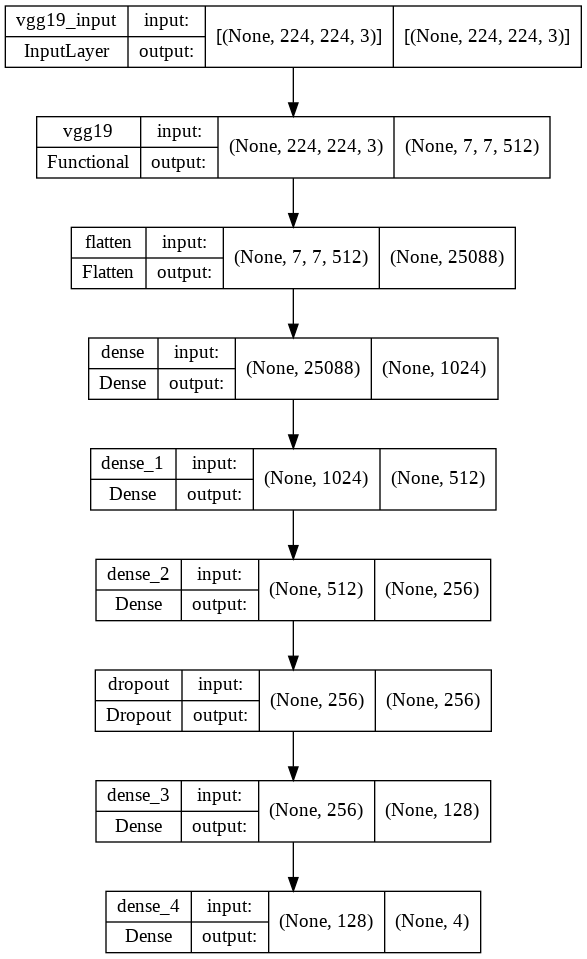

In [12]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png',show_shapes=True, show_layer_names=True)

In [ ]:
batch_size=32
epoch_size=10
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history = model.fit(train_generator, epochs=epoch_size, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator, validation_steps=STEP_SIZE_VALID)

Epoch 1/10


In [2]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key

    classes=list(new_dict.values()) 
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]
        if pred_index != true_index:
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count)
                plot_class.append(value)
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 40:
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [3]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True)
    return

In [4]:
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
p = model.predict(test_generator)
print_info( test_generator, p, 10, r'./', 'kidney' )  

NameError: ignored

In [5]:
model.evaluate(test_generator)

NameError: ignored